In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 3.47 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 6.3 MB/s 
     |████████████████████████████████| 448 kB 58.8 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-02-17 15:38:56--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
text_data = pd.read_csv("/content/gdrive/MyDrive/와이빅타/신입기수플젝/한국어_단발성_대화_데이터셋.csv", usecols=[0,1])
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
43666,NaN,NaN
43667,NaN,NaN
43668,NaN,NaN
43669,NaN,NaN


# 결측치, 중복값 삭제

In [5]:
text_data.isnull().any()

Sentence    True
Emotion     True
dtype: bool

In [6]:
text_data =text_data.dropna(axis=0) # 결측치 삭제

In [7]:
text_data['Sentence'].nunique(), text_data['Emotion'].nunique() # Sentece 열에서 중복 확인

(41534, 5)

In [8]:
text_data = text_data.drop_duplicates(subset=['Sentence']) # Sentece 열에서 중복 제거
print('총 텍스트 샘플 수 :', len(text_data))

총 텍스트 샘플 수 : 41534


In [9]:
text_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,걱정
1,그냥 내 느낌일뿐겠지?,걱정
2,아직너무초기라서 그런거죠?,걱정
3,유치원버스 사고 낫다던데,걱정
4,근데 원래이런거맞나요,걱정
...,...,...
41639,너무 힘들어요…,슬픔
41640,"저는 원래 자존감계속되는 취업 실패에 , 그것에 대한 부모님의 실망과 눈치를 정말 ...",슬픔
41641,아버지 술주정+어머니랑 떨어짐나혼자 아버지 술주정 감당 공부도 못 함.포기해야할까요...,슬픔
41642,너 그거알아? 나만 느끼는거인지 모르겠는데 너 진짜 예뻐 그리고 멋있어,행복


# Emotion 인코딩


In [10]:
# text_data[(text_data.Emotion == "분노") or (text_data.Emotion == "행복")]
N_P_text = text_data[(text_data['Emotion'].isin(["분노", "행복"]))]
N_P_text

,Sentence,Emotion
5468,서해 수자원도 한류라서 그동안 불법조업 방치했나?,분노
5469,니가 인간이가.,분노
5470,강아지를 때리고 유기하는것만 학대는 아닙니다!,분노
5471,하여간 우리나라 교육엔 미래가 없어!!,분노
5472,채널에이 군부 개인거 인증하냐 동아일보야!!,분노
...,...,...
41539,숫자로 평가되는 인생이 너무 싫다..,분노
41555,댓글보면서 힘 받고 아직 대한민국 살만한거같네요 마음이 따듯해진다..씨발,행복
41570,"자기 전에 누어서 보는데, 정말 뭔지 모르는 감동이 저려오는거 같아요.",행복
41597,제발 그만 끝내고 싶어..겨우겨우 버텨왔는데 모든게 몇번이고무너졌는데 지금까지 살아...,행복


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [12]:
label_encoder.fit(N_P_text.Emotion)
Emotion_encoded = label_encoder.transform(N_P_text.Emotion)

N_P_text.Emotion = Emotion_encoded
N_P_text

,Sentence,Emotion
5468,서해 수자원도 한류라서 그동안 불법조업 방치했나?,0
5469,니가 인간이가.,0
5470,강아지를 때리고 유기하는것만 학대는 아닙니다!,0
5471,하여간 우리나라 교육엔 미래가 없어!!,0
5472,채널에이 군부 개인거 인증하냐 동아일보야!!,0
...,...,...
41539,숫자로 평가되는 인생이 너무 싫다..,0
41555,댓글보면서 힘 받고 아직 대한민국 살만한거같네요 마음이 따듯해진다..씨발,1
41570,"자기 전에 누어서 보는데, 정말 뭔지 모르는 감동이 저려오는거 같아요.",1
41597,제발 그만 끝내고 싶어..겨우겨우 버텨왔는데 모든게 몇번이고무너졌는데 지금까지 살아...,1


In [13]:
print(label_encoder.classes_, "=>", label_encoder.transform(label_encoder.classes_))

['분노' '행복'] => [0 1]


# 훈련 데이터와 테스트 데이터 분리

In [14]:
train_data, test_data = train_test_split(N_P_text, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 14775
테스트용 리뷰의 개수 : 4926


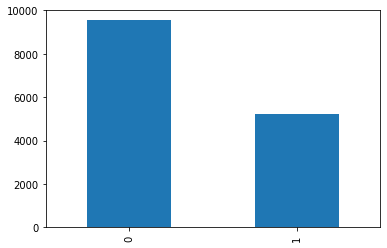

In [15]:
train_data['Emotion'].value_counts().plot(kind = 'bar')

# 토큰화

In [16]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게'] # 불용어

In [17]:
train_data['tokenized'] = train_data['Sentence'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['Sentence'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어와 길이 분포 확인

In [19]:
negative_words = np.hstack(train_data[train_data.Emotion == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.Emotion == 1]['tokenized'].values)

In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('.', 4774), ('?', 1513), ('!', 967), ('거', 856), ('있', 772), ('..', 772), ('나', 755), ('면', 754), ('안', 741), ('아', 727), ('냐', 712), ('없', 655), ('어', 586), ('말', 583), ('만', 555), ('으로', 528), ('로', 526), ('겠', 519), (',', 510), ('사람', 504)]


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('.', 2397), ('!', 1176), ('ㅋㅋㅋ', 677), ('좋', 604), ('감사', 455), ('있', 453), ('ㅋㅋ', 444), ('합니다', 441), ('너무', 403), ('잘', 384), ('해', 380), ('보', 367), ('주', 349), ('아', 344), ('네요', 338), ('습니다', 324), ('님', 319), ('..', 315), ('진짜', 295), ('~', 286)]


부정 리뷰의 평균 길이 : 10.971371644295303
긍정 리뷰의 평균 길이 : 9.965833174269898


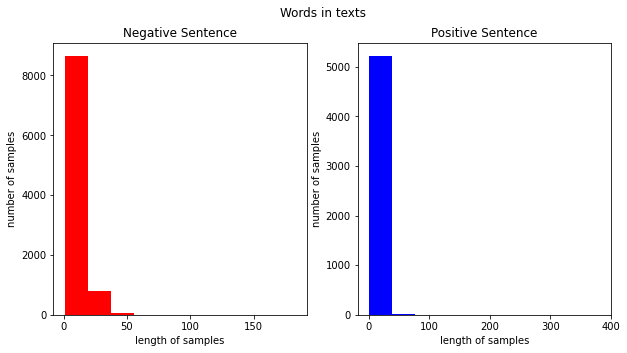

In [22]:
fig,(ax2,ax1) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['Emotion']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Negative Sentence')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['Emotion']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Positive Sentence')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

plt.show()

In [23]:
X_train = train_data['tokenized'].values
y_train = train_data['Emotion'].values
X_test= test_data['tokenized'].values
y_test = test_data['Emotion'].values

# 정수 인코딩

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 16404
등장 빈도가 1번 이하인 희귀 단어의 수: 8416
단어 집합에서 희귀 단어의 비율: 51.30455986344794
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.366183353099455


In [26]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7990


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [28]:
print(X_train[:3])

[[4351, 88, 257, 1814, 37, 54, 2], [1, 2661, 1, 44], [60, 291, 59, 16, 82, 69, 302]]


In [29]:
print(X_test[:3])

[[1149, 3510, 1, 293, 229, 43], [420, 697, 322, 2317, 10, 4], [4817, 1, 18, 5091]]


# 패딩

리뷰의 최대 길이 : 382
리뷰의 평균 길이 : 10.61482233502538


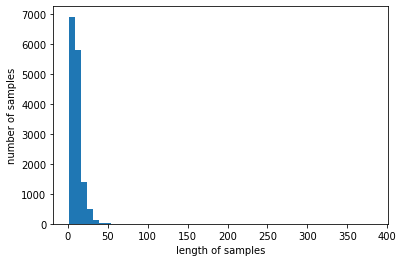

In [30]:
print('리뷰의 최대 길이 :',max(len(sentence) for sentence in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sentence) for sentence in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.91878172588832


In [33]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU로 감성 분류

In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
185/185 [==============================] - ETA: 0s - loss: 0.3577 - acc: 0.8459
Epoch 1: val_acc improved from -inf to 0.89983, saving model to best_model.h5
185/185 [==============================] - 32s 160ms/step - loss: 0.3577 - acc: 0.8459 - val_loss: 0.2400 - val_acc: 0.8998
Epoch 2/15
185/185 [==============================] - ETA: 0s - loss: 0.2035 - acc: 0.9228
Epoch 2: val_acc improved from 0.89983 to 0.91607, saving model to best_model.h5
185/185 [==============================] - 24s 132ms/step - loss: 0.2035 - acc: 0.9228 - val_loss: 0.2042 - val_acc: 0.9161
Epoch 3/15
185/185 [==============================] - ETA: 0s - loss: 0.1864 - acc: 0.9370
Epoch 3: val_acc improved from 0.91607 to 0.91980, saving model to best_model.h5
185/185 [==============================] - 25s 136ms/step - loss: 0.1864 - acc: 0.9370 - val_loss: 0.2099 - val_acc: 0.9198
Epoch 4/15
185/185 [==============================] - ETA: 0s - loss: 0.1427 - acc: 0.9455
Epoch 4: val_acc did not

In [35]:
loaded_model = load_model('best_model.h5')
loaded_model.save('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

154/154 [==============================] - 3s 18ms/step - loss: 0.2271 - acc: 0.9145

 테스트 정확도: 0.9145


In [36]:
# from google.colab import files
# files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# model = load_model('/content/gdrive/MyDrive/와이빅타/신입기수플젝/best_model.h5')

# 감성 예측

In [38]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [39]:
sentiment_predict('상수야 개패기전에 그만개겨라')

99.03% 확률로 부정 리뷰입니다.


In [40]:
sentiment_predict('무슨 똑같은말만 40분을 하네 ;;;;')

99.68% 확률로 부정 리뷰입니다.


In [41]:
sentiment_predict('귀요미 끝판왕')

90.13% 확률로 긍정 리뷰입니다.


In [42]:
sentiment_predict('형 나 형 쇼미하는거 보고왔서 형 랩 엄청 잘하네!! 열심히해!!')

99.64% 확률로 긍정 리뷰입니다.


In [43]:
sentiment_predict('상수야 현피 함 뜨자 연락해라')

96.99% 확률로 부정 리뷰입니다.


In [44]:
sentiment_predict('방송 접자 그냥.')

73.38% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict('상수야 경찰 떳는데 혹시 또 테이저건 맞았냐?')

98.37% 확률로 부정 리뷰입니다.


In [46]:
sentiment_predict('진짜 요즘 텐션 지렸다ㅋㅋ')

97.71% 확률로 긍정 리뷰입니다.


In [47]:
sentiment_predict('상수야 나 5살인데 말 놓을게')

93.41% 확률로 부정 리뷰입니다.


In [48]:
sentiment_predict('형님  여자친구와 오늘 헤어젔습니다   울어야하는데  형님 방송보면서 실실 쪼개고 있는  저 자신이 ㅄ같지만  형님떄문에 힘이납니다  맨날 방송해주세요  그래야 다시일어설수있을꺼같습니다')

98.94% 확률로 긍정 리뷰입니다.


In [49]:
sentiment_predict('상수형 진짜 저랑 생방으로 딱 한번만 현피떠주시면 안될까요?')

56.75% 확률로 부정 리뷰입니다.


In [50]:
sentiment_predict('나잇값 못하이 맞았겠지 상수야 ㅋㅋㅋㅋㅋ')

64.34% 확률로 부정 리뷰입니다.


In [51]:
sentiment_predict('나랑 현피 뜨실 니어디산 아 대구에 산다 탈모 병신 새끼야')

99.93% 확률로 부정 리뷰입니다.
